# Sabermetrics: The Air Quality Factor

In this Jupyter notebook I will explore the relationship between baseball performance and atmospheric air quality. The first step in this project is to import the multiple data sets with the goal of building a shared data frame so that the data can be easily compared using Pandas.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline

#Set filepaths for baseball data and atmospheric data
team_path = "C:\Users\Nathan\Documents\GitHub\SabermetricsProject\Data\Teams.csv"
epa_yearly_path = "C:\Users\Nathan\Documents\GitHub\SabermetricsProject\Data\epa_air_quality_annual_summary.csv"

team_DF = pd.read_csv(team_path)
epa_yearly_DF = pd.read_csv(epa_yearly_path)

#Rename columns to make table joins easier down the line
team_DF.rename(columns={"yearID":"year"},inplace=True)


#Print various stats about the data and dataframe
print("Original dataframe size = %s" %epa_yearly_DF.size)
print("Memory usage for EPA yearly summary = %s" % epa_yearly_DF.memory_usage)



C:\Users\Nathan\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Original dataframe size = 112129050
Memory usage for EPA yearly summary = <bound method DataFrame.memory_usage of         state_code  county_code  site_num  parameter_code  poc   latitude  \
0               20           57         1           82134    1  37.771964   
1               18          163        12           42401    1  38.021727   
2               40           31      9000           88152    1  34.732404   
3               32            3       561           42601    1  36.163959   
4               13          127      3001           12154    1  31.185187   
5               45           45         8           88313    1  34.838814   
6               06           99         2           83152    5  37.648819   
7               06           43         3           88342    1  37.713250   
8               42          101         4           45201    2  40.008889   
9               06           41         1           43815    3  37.972310   
10              50            3      80

Now that the data has been imported, the next  step is to clean the data by removing unneeded information and then  try to determine a shared key/column so that the dataframes can be merged. The epa readings contained in the dataframe were collected at a variety of cities within the US, many without any professional baseball team. There also may be cities that have atmospheric readings but no MLB team. Therefore I will identify the cities contained within both datasets and use these for my analysis. In addition, a new column within the team dataframe needs to be created that contains the city the team is located in. This can be derived by stripping the city name off the front of the team organization name.

Reduced dataframe size by 13353175


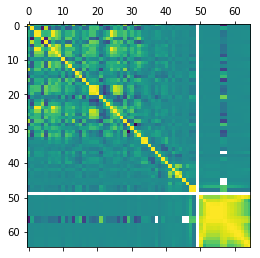

In [3]:
#Create a list of distinct cities where readings were collected
distinct_cities = epa_yearly_DF.city_name.unique()
MLB_cities = ["Baltimore","Boston","Chicago","Cleveland","Detroit","Houston","Kansas City","Anaheim",
             "Minneapolis","New York","Oakland","Seattle","St. Petersburg","Arlington","Phoenix",
             "Atlanta","Cincinnati","Denver","Los Angeles","Miami","Milwaukee","Philadelphia",
             "Pittsburgh","San Diego","San Francisco","St. Louis","Washington","St. Paul","Newark",]

shared_cities = [x for x in distinct_cities if x in MLB_cities]
epa_yearly_DF = epa_yearly_DF[epa_yearly_DF['city_name'].isin(shared_cities)]

print("Reduced dataframe size by %s" %epa_yearly_DF.size)

#Create a dictionary mapping teams to cities
team_cities = team_DF.name.unique()
team_to_city = {}
for words in team_cities:
    wordsList = words.split(" ")
    if wordsList[0]=="Kansas" or wordsList[0]=="San" or wordsList[0]=="Los" or wordsList[0]=="New" or wordsList[0]=="St.":
        team_to_city[words] = wordsList[0]+" "+wordsList[1]
    else:
        team_to_city[ words] = wordsList[0]

#Add new city_name column to team dataframe to act as key for joining
team_DF["city_name"] = "default"

for index,row in team_DF.iterrows():
    if row["name"] in team_to_city:
        team_DF.set_value(index,"city_name",team_to_city[row["name"]])

merged_DF = pd.merge(team_DF,epa_yearly_DF,on=["year","city_name"])

plt.matshow(merged_DF.corr())

The correlation matrix above is way too large and is a mess. Therefore I will seperate the team columns into focus areas to try to make the important correlations more apparent.

In [4]:
team_col = ["W","H","2B","3B","ERA","FP","HR","SO","SF","E","teamID","year","city_name"]
stats_team_DF = team_DF[team_col]

merged_DF = pd.merge(stats_team_DF,epa_yearly_DF,on=["year","city_name"])

s = merged_DF.corr().unstack()
so = s.sort_values(kind="quicksort",ascending=False)

focus = ['W','ERA',"H","2B","3B","FP","HR","SO","E","SF"]
merged_DF.corr().filter(focus).drop(focus)

,W,ERA,H,2B,3B,FP,HR,SO,E,SF
year,0.103986,0.016280,0.079861,0.323241,-0.251888,0.559977,0.295951,0.737000,-0.510111,-0.203673
county_code,-0.028952,0.039561,0.015973,-0.009726,0.054882,0.047573,-0.039420,-0.113179,-0.032096,0.028857
site_num,0.046779,-0.114188,-0.009427,-0.059859,0.004963,0.054025,-0.097945,0.025515,-0.051175,-0.036956
parameter_code,0.081462,0.056529,0.108225,0.201229,-0.144662,0.202238,0.173891,0.235730,-0.182232,-0.036254
poc,0.097523,-0.067067,0.070567,0.120021,-0.054802,0.156079,0.062519,0.127196,-0.134670,-0.001641
latitude,0.000637,0.151073,0.111936,0.083421,-0.044560,0.018860,0.155795,-0.034152,-0.031942,0.060464
longitude,0.059715,0.116239,0.086355,0.168792,-0.062505,0.001550,0.206026,0.005677,-0.006929,0.061771
observation_count,-0.035513,-0.030333,-0.041880,-0.065306,0.034678,-0.066843,-0.073474,-0.042649,0.064627,-0.001886
observation_percent,0.037524,0.027401,0.068226,0.116529,-0.055774,0.097972,0.066071,0.070629,-0.077088,0.015384
valid_day_count,-0.020782,-0.038420,-0.024510,-0.044575,0.019473,-0.047955,-0.067689,-0.033792,0.052025,-0.006616


From the table above we can see that there are not any significant correlations between the datasets. In the comparison above all different atmospheric readings are being lumped together and treated as the same. With over 1000 unique reading types it does not really make sense to keep them lumped together. Lets see if there are any correlations between a few specific reading types.

In [5]:
sulfurdioxide_DF = merged_DF[merged_DF["parameter_name"] == "Sulfur dioxide"]

focus = ['W','ERA',"H","2B","3B","FP","HR","SO","E","SF"]
sulfurdioxide_DF.corr().filter(focus).drop(focus)

,W,ERA,H,2B,3B,FP,HR,SO,E,SF
year,0.109469,0.258738,0.186516,0.499711,-0.281702,0.621925,0.434604,0.756991,-0.539609,-0.127361
county_code,-0.000669,-0.023015,-0.041185,-0.067368,0.094357,0.084203,-0.070878,-0.016798,-0.061115,-0.061202
site_num,0.021713,-0.021419,0.020168,-0.003732,-0.047422,0.048280,-0.005615,0.057000,-0.042585,-0.017917
parameter_code,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
poc,0.006296,-0.075081,-0.044872,-0.059233,-0.011359,0.028667,-0.042682,0.062222,-0.027063,-0.049556
latitude,-0.014117,0.211739,0.100779,0.075642,-0.038463,-0.051219,0.165280,-0.144869,0.025396,0.147260
longitude,0.087707,0.045141,0.078181,0.112335,-0.089095,-0.055710,0.126426,-0.093834,0.034318,0.144595
observation_count,0.017925,-0.026101,-0.008054,0.025688,-0.043257,0.100419,0.027575,0.142889,-0.083724,-0.051246
observation_percent,0.008425,0.104744,0.077451,0.123333,-0.076080,0.047431,0.041109,0.093668,-0.008353,0.021655
valid_day_count,0.013075,0.104908,0.083594,0.134422,-0.083268,0.048842,0.044147,0.102567,-0.008483,0.021646


After isolating atmospheric records for Sulfur Dioxide we can start seeing some meaningful results Notably there is a negative correlation (-0.384775) between the average sulfur dioxide concentrations and strike out rates. There is also a noteable negative correlation (-0.316838) with fielding percentage. Next we will examine the correlation of ozone.

In [17]:
ozone_DF = merged_DF[merged_DF["parameter_name"] == "Ozone"]
focus = ['W','ERA',"H","2B","3B","FP","HR","SO","E","SF"]
ozone_DF.corr().filter(focus).drop(focus)

,W,ERA,H,2B,3B,FP,HR,SO,E,SF
year,0.043442,0.245016,0.120264,0.468783,-0.391729,0.598138,0.469250,0.771023,-0.538369,-0.211712
county_code,0.008075,-0.071492,-0.021490,-0.018899,0.099481,0.058192,-0.121628,-0.024318,-0.029454,-0.024091
site_num,0.026146,-0.097912,-0.015898,-0.029748,-0.003814,0.068031,-0.053369,0.085574,-0.059547,-0.063127
parameter_code,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
poc,-0.027954,-0.034971,-0.045040,-0.033858,0.016785,-0.040480,-0.018841,-0.004904,0.026716,-0.005824
latitude,-0.000818,0.199562,0.096378,0.005622,-0.024201,-0.037740,0.147310,-0.158937,0.013891,0.099704
longitude,0.047024,0.093769,0.073166,0.087265,-0.071611,0.020160,0.137662,-0.047973,-0.032657,0.075400
observation_count,0.022104,-0.060791,-0.024963,0.040364,-0.055825,0.116708,-0.003076,0.140430,-0.100876,-0.112579
observation_percent,-0.024228,0.118383,0.031525,0.111366,-0.090943,0.128980,0.068780,0.126141,-0.117207,-0.063185
valid_day_count,-0.025184,-0.074299,-0.069324,0.027533,-0.070236,0.089132,-0.044622,0.205711,-0.066924,-0.137167


In [19]:
carbonmonoxide_DF = merged_DF[merged_DF["parameter_name"] == "Carbon monoxide"]
focus = ['W','ERA',"H","2B","3B","FP","HR","SO","E","SF"]
carbonmonoxide_DF.corr().filter(focus).drop(focus)

,W,ERA,H,2B,3B,FP,HR,SO,E,SF
year,0.125714,0.210088,0.180349,0.486171,-0.280398,0.617733,0.419289,0.758022,-0.537608,-0.113645
county_code,0.009485,-0.015375,-0.014391,-0.060819,0.048399,0.108337,-0.043104,-0.046530,-0.083682,-0.032979
site_num,0.058743,-0.105751,0.002469,-0.004435,-0.016635,0.107963,-0.035562,0.137051,-0.094287,-0.070437
parameter_code,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
poc,0.038577,-0.062486,-0.002206,0.007796,-0.019910,0.068829,0.002161,0.064157,-0.063305,-0.023233
latitude,-0.037565,0.225975,0.092205,0.087821,-0.052102,-0.034852,0.173388,-0.157465,0.008795,0.122497
longitude,0.083551,0.022315,0.068437,0.115601,-0.041173,0.024020,0.092970,-0.021894,-0.029864,0.102698
observation_count,-0.003402,0.070038,0.034634,0.069158,-0.084689,0.047003,0.025447,0.044290,-0.036970,0.030669
observation_percent,-0.004174,0.069946,0.033718,0.068604,-0.084548,0.046905,0.024562,0.043868,-0.037232,0.030202
valid_day_count,-0.000488,0.078181,0.041416,0.084306,-0.091745,0.060854,0.035030,0.064613,-0.048381,0.030654


In [20]:
particulate_DF = merged_DF[merged_DF["parameter_name"] == "Suspended particulate (TSP)"]
particulate_DF.corr().filter(focus).drop(focus)

,W,ERA,H,2B,3B,FP,HR,SO,E,SF
year,0.139431,0.332199,0.211157,0.542590,-0.313514,0.509662,0.473604,0.670212,-0.392950,-0.003091
county_code,0.051153,-0.172642,-0.095325,-0.180659,0.108970,0.113688,-0.128150,-0.132404,-0.084310,-0.090923
site_num,-0.009448,-0.026511,-0.003009,-0.034077,0.018637,0.035352,-0.080180,-0.025134,-0.037531,-0.013991
parameter_code,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
poc,0.017918,0.034916,0.013349,0.026793,-0.059817,0.109179,0.020648,0.029693,-0.100095,-0.007390
latitude,-0.069728,0.420123,0.108789,0.208722,-0.239368,0.094257,0.312006,0.077429,-0.093743,0.096993
longitude,0.082722,0.109738,0.064940,0.153842,-0.195476,0.065803,0.161000,0.060094,-0.078219,0.131548
observation_count,-0.018637,0.049663,0.002005,-0.021705,-0.003768,-0.013450,-0.012209,-0.047196,0.009099,0.026538
observation_percent,0.055516,0.054192,0.072975,0.046256,0.018705,0.031274,0.078042,-0.005630,0.007261,0.045992
valid_day_count,0.060305,0.037526,0.066153,0.039587,0.025305,0.020245,0.067403,-0.022130,0.012563,0.049657


In [21]:

hydrocarbon_DF = merged_DF[merged_DF["parameter_name"] == "Total hydrocarbons"]
hydrocarbon_DF.corr().filter(focus).drop(focus)

,W,ERA,H,2B,3B,FP,HR,SO,E,SF
year,0.348843,0.638573,0.468975,0.714955,-0.387803,0.617479,0.718751,0.730706,-0.535149,0.077019
county_code,-0.008440,-0.212650,-0.023692,-0.054407,0.244557,-0.071249,-0.172560,-0.286232,0.102898,0.081322
site_num,-0.200017,-0.419188,-0.250634,-0.440461,0.103331,-0.368335,-0.379818,-0.273780,0.305205,-0.097045
parameter_code,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
poc,0.034965,-0.026217,0.013259,-0.016679,0.120972,0.052204,-0.077014,-0.070162,-0.030566,0.109702
latitude,0.327146,0.526332,0.355357,0.585266,-0.436171,0.492269,0.633429,0.395384,-0.437456,0.110656
longitude,0.387553,0.331436,0.371175,0.550931,-0.238403,0.462370,0.512822,0.291218,-0.409752,0.131148
observation_count,0.022480,0.244042,0.119583,0.165218,-0.210742,0.057441,0.198275,0.216154,-0.062356,0.000064
observation_percent,0.096591,0.298225,0.177938,0.241200,-0.268812,0.166275,0.282675,0.261865,-0.160144,0.017671
valid_day_count,0.028951,0.266407,0.124502,0.184664,-0.224987,0.077590,0.220203,0.244230,-0.081695,0.012123


In [22]:
temperature_DF = merged_DF[merged_DF["parameter_name"] == "Average Ambient Temperature"]
temperature_DF.corr().filter(focus).drop(focus)

,W,ERA,H,2B,3B,FP,HR,SO,E,SF
year,-0.059119,-0.409481,-0.380151,-0.254244,-0.008274,0.351142,-0.251561,0.561172,-0.362085,-0.270195
county_code,-0.088590,0.113118,0.082872,0.018097,-0.001596,-0.003587,-0.062831,-0.180598,0.018361,0.044350
site_num,0.032932,-0.152895,-0.085248,-0.165824,0.056122,0.046642,-0.155984,-0.000882,-0.042144,-0.038737
parameter_code,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
poc,0.046362,-0.135053,-0.042572,-0.047118,0.008327,0.067267,-0.098677,0.025596,-0.062872,-0.028042
latitude,0.025471,0.084097,0.104672,0.116385,-0.063954,0.004745,0.139371,-0.014776,-0.022400,0.059320
longitude,0.101749,0.050114,0.069509,0.188701,-0.115204,-0.007235,0.248080,0.048189,-0.003300,0.015583
observation_count,0.041923,-0.007335,0.038887,0.039985,0.032654,0.007694,0.010081,-0.075279,-0.000793,0.030395
observation_percent,-0.000549,-0.004544,0.022708,0.059093,0.036396,-0.053918,-0.071341,-0.110956,0.054806,0.000051
valid_day_count,0.046279,-0.070743,-0.028140,-0.030910,0.003900,0.060530,-0.014655,-0.012143,-0.058134,-0.050626


In [23]:
wind_DF = merged_DF[merged_DF["parameter_name"] == "Wind Speed - Resultant"]
wind_DF.corr().filter(focus).drop(focus)

,W,ERA,H,2B,3B,FP,HR,SO,E,SF
year,0.000056,0.234971,0.100195,0.339287,-0.388662,0.604835,0.437874,0.724386,-0.580682,-0.300385
county_code,0.042659,-0.103799,0.052561,0.098533,0.039169,0.021227,-0.086320,-0.042875,0.008922,-0.013753
site_num,-0.023369,-0.017251,-0.037150,-0.040067,-0.039876,0.031592,-0.077326,0.025570,-0.026805,-0.042652
parameter_code,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
poc,0.059098,-0.070632,-0.003325,-0.006878,-0.027162,0.071356,0.028698,0.072847,-0.066553,-0.007006
latitude,0.133576,0.131635,0.233970,0.123096,-0.047873,0.159724,0.287336,0.070723,-0.173260,-0.010772
longitude,0.140278,0.045009,0.171607,0.150077,-0.011611,0.094085,0.197288,-0.025838,-0.096670,0.049289
observation_count,-0.048619,-0.042038,-0.028473,-0.023529,-0.014996,0.009448,-0.099136,0.015178,0.006951,-0.048935
observation_percent,-0.010092,-0.071975,-0.022081,-0.007411,-0.030071,0.056856,-0.101349,0.005326,-0.039940,-0.036082
valid_day_count,-0.043815,-0.025969,-0.003641,-0.020711,-0.007809,0.012315,-0.080081,0.026036,0.002317,-0.049755
